# Trian Test Split (70 - 15 - 15)

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.optimize import minimize
from scipy.special import betaln, gammaln
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('model_data.csv')
games = pd.read_csv('data/games.csv')
plays = pd.read_csv('data/plays.csv')
player_play = pd.read_csv('data/player_play.csv')
players = pd.read_csv('data/players.csv')

In [3]:
qbs = pd.merge(player_play, players.loc[:, ['nflId', 'position', 'displayName']], on = 'nflId', how='left')
qbs = qbs.loc[qbs['position'] == 'QB']

In [4]:
data = pd.merge(data, qbs.loc[:, ['gameId', 'playId', 'nflId', 'displayName']], on = ['gameId', 'playId'], how = 'left')
data = data.rename({'nflId':'qbId', 'displayName':'qbName'}, axis=1)

In [5]:
pressure_rate = data.groupby('qbId')['causedPressure'].agg(['sum', 'count'])
overall_mean = data['causedPressure'].mean()

In [6]:
def beta_binomial_pmf(k, n, alpha, beta):
    """
    Probability mass function for the beta-binomial distribution
    
    Parameters:
    k: number of successes
    n: number of trials
    alpha, beta: parameters of the beta distribution
    """
    pmf = np.exp(
        gammaln(n + 1) - gammaln(k + 1) - gammaln(n - k + 1) +
        gammaln(k + alpha) + gammaln(n - k + beta) - gammaln(n + alpha + beta) +
        gammaln(alpha + beta) - gammaln(alpha) - gammaln(beta)
    )
    return pmf

def neg_log_likelihood(params, data):
    """
    Negative log likelihood function for the beta-binomial distribution
    
    Parameters:
    params: [alpha, beta]
    data: list of tuples (successes, trials)
    """
    alpha, beta = params
    if alpha <= 0 or beta <= 0:  # Parameters must be positive
        return np.inf
    
    log_likelihood = 0
    for successes, trials in data:
        p = beta_binomial_pmf(successes, trials, alpha, beta)
        if p > 0:
            log_likelihood += np.log(p)
        else:
            return np.inf
    
    return -log_likelihood

def fit_beta_binomial(data, overall_mean):
    """
    Fit beta-binomial distribution using MLE with constraint alpha/(alpha+beta) = overall_mean
    
    Parameters:
    data: list of tuples (successes, trials)
    overall_mean: target mean rate
    
    Returns:
    alpha, beta: optimized parameters
    """
    def objective(x):
        # x is alpha, beta is determined by constraint
        alpha = x[0]
        beta = alpha * (1 - overall_mean) / overall_mean
        return neg_log_likelihood([alpha, beta], data)
    
    # Initial guess for alpha (try a few values)
    best_result = None
    best_value = np.inf
    
    for init_alpha in [1, 5, 10, 20]:
        result = minimize(
            objective,
            x0=[init_alpha],
            method='L-BFGS-B',
            bounds=[(0.0001, None)],
        )
        
        if result.fun < best_value:
            best_value = result.fun
            best_result = result
    
    final_alpha = best_result.x[0]
    final_beta = final_alpha * (1 - overall_mean) / overall_mean
    
    return final_alpha, final_beta

# Example data: list of (successes, trials) for each player
data_tups = list(pressure_rate.itertuples(index=False, name=None))     # Player 3: 3 successes in 5 trials

# Calculate overall mean from data
overall_mean = data['causedPressure'].mean()

# Fit the model
alpha, beta = fit_beta_binomial(data_tups, overall_mean)
print(f"Fitted parameters: alpha = {alpha:.2f}, beta = {beta:.2f}")

Fitted parameters: alpha = 20.02, beta = 39.59


In [7]:
pressure_rate['count'] =  pressure_rate['count'] + alpha + beta
pressure_rate['sum'] =  pressure_rate['sum'] + alpha
pressure_rate['qb_pressured_rate'] = pressure_rate['sum'] / pressure_rate['count']
pressure_rate = pressure_rate.reset_index()

In [8]:
data = pd.merge(data, pressure_rate.loc[:, ['qbId', 'qb_pressured_rate']], on = 'qbId', how='left')

In [9]:
scaler = StandardScaler()
data['qb_pressured_rate'] = scaler.fit_transform(data['qb_pressured_rate'].values.reshape(-1, 1))

In [45]:
data

,causedPressure,critical_down,long_distance,close_endzone,close_safety,low_play_clock,qb_pressured_rate
0,0,0.0,0.0,0.0,0.0,0.0,-0.427599
1,1,0.0,0.0,0.0,0.0,0.0,-0.427599
2,1,0.0,0.0,0.0,0.0,0.0,-0.427599
3,0,0.0,0.0,0.0,0.0,0.0,-0.427599
4,0,0.0,0.0,0.0,0.0,0.0,-0.427599
...,...,...,...,...,...,...,...
9759,0,1.0,0.0,0.0,0.0,0.0,-1.006161
9760,1,0.0,0.0,0.0,0.0,0.0,-1.006161
9761,0,0.0,0.0,0.0,0.0,0.0,-1.006161
9762,0,0.0,0.0,0.0,0.0,0.0,-1.006161


<Axes: xlabel='causedPressure', ylabel='timeToThrow'>

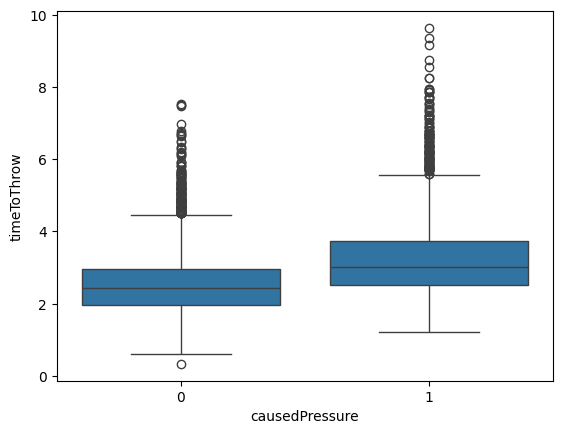

In [10]:
sns.boxplot(x='causedPressure', y = 'timeToThrow', data=data)

In [11]:
data.groupby('dropbackType')['causedPressure'].mean()

dropbackType
DESIGNED_ROLLOUT_LEFT     0.268421
DESIGNED_ROLLOUT_RIGHT    0.262162
DESIGNED_RUN              0.357143
SCRAMBLE                  0.622485
SCRAMBLE_ROLLOUT_LEFT     0.370370
SCRAMBLE_ROLLOUT_RIGHT    0.504065
TRADITIONAL               0.308518
Name: causedPressure, dtype: float64

In [12]:
data.loc[data['playClockAtSnap'] < 2, 'low_play_clock'] = 1.0
data['low_play_clock'] = data['low_play_clock'].fillna(0.0)

In [13]:
data.groupby('low_play_clock')['causedPressure'].mean()

low_play_clock
0.0    0.335438
1.0    0.350000
Name: causedPressure, dtype: float64

In [14]:
data.loc[data['absoluteYardlineNumber'] < 15, 'close_endzone'] = 1.0
data['close_endzone'] = data['close_endzone'].fillna(0.0)

In [15]:
data.loc[data['absoluteYardlineNumber'] > 100, 'close_safety'] = 1.0
data['close_safety'] = data['close_safety'].fillna(0.0)

In [16]:
data.groupby('close_endzone')['causedPressure'].mean()

close_endzone
0.0    0.337139
1.0    0.238462
Name: causedPressure, dtype: float64

In [17]:
def time_to_minutes(time_str):
    minutes, seconds = map(int, time_str.split(":"))
    return minutes + (seconds / 60)

In [18]:
data['gameClock'] = data['gameClock'].apply(lambda x: time_to_minutes(x))
data.loc[(data['quarter'].isin([2, 4])) & (data['gameClock'] < 2), 'two_minute_drill'] = 1.0
data['two_minute_drill'] = data['two_minute_drill'].fillna(0.0)
data.groupby('two_minute_drill')['causedPressure'].mean()

two_minute_drill
0.0    0.331487
1.0    0.364559
Name: causedPressure, dtype: float64

In [19]:
data = pd.merge(data, games.loc[:, ['gameId', 'homeTeamAbbr', 'visitorTeamAbbr']], on = 'gameId', how ='left')

In [20]:
data.loc[data['down'].isin([3, 4]), 'critical_down'] = 1.0
data['critical_down'] = data['critical_down'].fillna(0.0)

In [21]:
#data.loc[data['possessionTeam'] == data['homeTeamAbbr'], 'score_diff'] = data['preSnapHomeScore'] - data['preSnapVisitorScore'] 
#data.loc[data['possessionTeam'] == data['visitorTeamAbbr'], 'score_diff'] = data['preSnapVisitorScore'] - data['preSnapHomeScore'] 
#data['binned_score_diff'] = pd.qcut(data['score_diff'], q=8)

In [22]:
data['avg_yards_to_go'] = data['yardsToGo']/(4-data['down'].clip(upper=3))
data.loc[data['avg_yards_to_go'] > 5, 'long_distance'] = 1.0
data['long_distance'] = data['long_distance'].fillna(0.0)

In [23]:
data.groupby('long_distance')['causedPressure'].agg(['mean', 'count'])

,mean,count
long_distance,,
0.0,0.309217,7367
1.0,0.417605,2397


In [24]:
data.groupby(['critical_down'])['causedPressure'].agg(['mean', 'count'])

,mean,count
critical_down,,
0.0,0.299378,6911
1.0,0.424115,2853


In [25]:
#data.groupby('binned_score_diff')['causedPressure'].agg(['mean', 'count'])

In [26]:
#data.loc[data['score_diff'] >= 14, 'big_score_diff'] = 1.0
#data['big_score_diff'] = data['big_score_diff'].fillna(0.0)

In [27]:
# Feature 1: offenseFormation
data['offenseFormation'].value_counts()
off_formation_mapping = {'SHOTGUN':1, 'SINGLEBACK':0, 'EMPTY':1, 'I_FORM':0, 'PISTOL':0,
                         'JUMBO':0, 'WILDCAT':1}

data['is_shotgun'] = data['offenseFormation'].map(off_formation_mapping)


In [28]:
data.groupby('is_shotgun')['causedPressure'].agg(['mean', 'count'])

,mean,count
is_shotgun,,
0,0.338330,1868
1,0.335233,7896


In [29]:
data = data.loc[:, ['causedPressure', 'critical_down', 'long_distance', 'close_endzone', 'close_safety', 'low_play_clock', 'qb_pressured_rate']]

In [30]:
# Replace 'target' with the actual column name of your target variable
X = data.drop(columns=['causedPressure'])  # Features
y = data['causedPressure']  # Target variable

# Step 1: Split into train and temp (70-30 split)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 2: Split temp into validation and test (50-50 split of the remaining 30%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

"""
train = pd.concat([X_train, y_train], axis=1)
# Step 1: Count the number of rows where causedPressure is 1
count_pressure_1 = train[train['causedPressure'] == 1].shape[0]
print(f"Number of rows where causedPressure is 1: {count_pressure_1}")

count_pressure_0 = train[train['causedPressure'] == 0].shape[0]
print(f"Number of rows where causedPressure is 0: {count_pressure_0}")

# Step 2: Randomly sample the same number of rows where causedPressure is 0
sampled_pressure_0 = train[train['causedPressure'] == 0].sample(n=count_pressure_1, random_state=42)

# Step 3: Get all rows where causedPressure is 1
pressure_1 = train[train['causedPressure'] == 1]

# Step 4: Concatenate the sampled rows with the rows where causedPressure is 1
balanced_final_df = pd.concat([sampled_pressure_0, pressure_1])

X_train = balanced_final_df.drop('causedPressure', axis=1)
y_train = balanced_final_df['causedPressure']
"""

# Print the sizes of each dataset
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])


Training set size: 6834
Validation set size: 1465
Test set size: 1465


In [31]:
# Print the percentage of positive examples in the y_train, y_val, and y_test
print("Percentage of positive examples in y_train:", y_train.mean())
print("Percentage of positive examples in y_val:", y_val.mean())
print("Percentage of positive examples in y_test:", y_test.mean())

Percentage of positive examples in y_train: 0.3358208955223881
Percentage of positive examples in y_val: 0.33583617747440275
Percentage of positive examples in y_test: 0.33583617747440275


# Baseline Model

Validation Metrics:
Mean Absolute Error (MAE): 0.3345
Mean Squared Error (MSE): 0.3345
R² Score: -0.4995

Test Metrics:
Mean Absolute Error (MAE): 0.3447
Mean Squared Error (MSE): 0.3447
R² Score: -0.5454

Sample Predictions:
      Actual  Predicted
3108       0          0
482        0          0
5076       0          0
9057       1          0
6418       1          0
Test Accuracy: 0.6553
Confusion Matrix:
[[932  41]
 [464  28]]


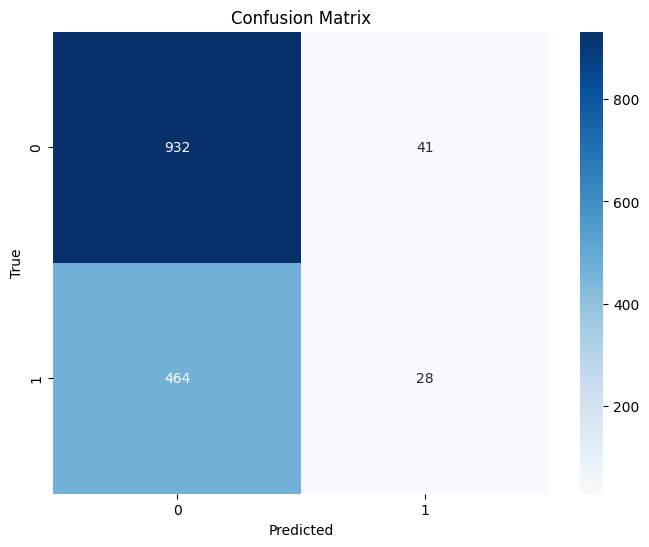

In [32]:
# Initialize and train the Linear Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on validation and test sets
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Evaluate the model on the validation set
print("Validation Metrics:")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_val, y_val_pred):.4f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_val, y_val_pred):.4f}")
print(f"R² Score: {r2_score(y_val, y_val_pred):.4f}")

# Evaluate the model on the test set
print("\nTest Metrics:")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_test_pred):.4f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_test_pred):.4f}")
print(f"R² Score: {r2_score(y_test, y_test_pred):.4f}")

# Optional: Compare actual vs predicted values on the test set
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
print("\nSample Predictions:")
print(results.head())

# Calculate accuracy
accuracy = accuracy_score(y_test, y_test_pred.round())
print(f"Test Accuracy: {accuracy:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred.round())

# Print the raw confusion matrix
print("Confusion Matrix:")
print(cm)

# Optional: Visualize the confusion matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [33]:
model_weights = pd.DataFrame(index = X.columns)

In [34]:
model_weights['odds_multiplier'] = np.exp(model.coef_).reshape(-1)

In [35]:
model_weights

,odds_multiplier
critical_down,1.558519
long_distance,1.210239
close_endzone,0.687867
close_safety,0.800838
low_play_clock,0.971917
qb_pressured_rate,1.361245


# XGBoost model

# Hyperparamater Tuning

In [46]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np

# 1. Define a parameter grid for XGBoost hyperparameters
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.1, 0.01, 0.001],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "reg_lambda": [0, 1, 10],
    "eta": np.logspace(-3, 0, 4)
}

# 2. Initialize an XGBoost classifier
xgb_clf = XGBClassifier(
    objective="binary:logistic", 
    reg_lambda=150,
    scale_pos_weight = 2 # 0 class is twice as likely as 1 class
)

# 3. Instantiate the RandomizedSearchCV
#    n_iter: number of random parameter settings to try
#    cv: number of folds in cross-validation
#    scoring: metric used for selection
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=20,                  # Adjust to your preference
    scoring=['neg_log_loss', 'f1', 'roc_auc'],
    refit='neg_log_loss',         
    cv=3,                       # K-fold cross-validation               # Use all available cores
)

#clf = RandomizedSearchCV(tree, param_dict, n_iter=100, cv=5, verbose=2, random_state=1234, scoring=['neg_log_loss', 'f1', 'roc_auc'], refit='neg_log_loss')

# fit the model

# 4. Fit the RandomizedSearchCV on your training set
random_search.fit(X_train, y_train)

# print the best parameters and scores
cv_results = random_search.cv_results_
print(f"Best Parameters: {random_search.best_params_}")

df_cv_results = pd.DataFrame(cv_results)
df_cv_results.sort_values(by=["rank_test_neg_log_loss", "rank_test_f1", "rank_test_roc_auc"], ascending=[True, True, True], inplace=True)
print(f"Min Neg Log Loss = {df_cv_results['mean_test_neg_log_loss'].max():.3f} | Max F1 Score = {df_cv_results['mean_test_f1'].max():.3f} | Max AUC Score = {df_cv_results['mean_test_roc_auc'].max():.3f}")
df_cv_results[["params", "mean_test_neg_log_loss", "rank_test_neg_log_loss", "mean_test_f1", "rank_test_f1", "mean_test_roc_auc", "rank_test_roc_auc"]].head()


Best Parameters: {'subsample': 0.8, 'reg_lambda': 0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'eta': np.float64(0.01), 'colsample_bytree': 0.8}
Min Neg Log Loss = -0.678 | Max F1 Score = 0.493 | Max AUC Score = 0.605


,params,mean_test_neg_log_loss,rank_test_neg_log_loss,mean_test_f1,rank_test_f1,mean_test_roc_auc,rank_test_roc_auc
6,"{'subsample': 0.8, 'reg_lambda': 0, 'n_estimat...",-0.677520,1,0.475669,7,0.604800,2
15,"{'subsample': 1.0, 'reg_lambda': 10, 'n_estima...",-0.678114,2,0.482566,4,0.604337,4
2,"{'subsample': 0.8, 'reg_lambda': 10, 'n_estima...",-0.679210,3,0.454782,17,0.595192,8
1,"{'subsample': 1.0, 'reg_lambda': 0, 'n_estimat...",-0.680587,4,0.474445,8,0.595140,9
14,"{'subsample': 1.0, 'reg_lambda': 0, 'n_estimat...",-0.680587,4,0.474445,8,0.595140,9


In [49]:
# 5. Create and train the XGBoost model
#    - We use early stopping on the validation set to avoid overfitting.
params_opt = {"objective": "binary:logistic", "max_depth": 6, "eta": 0.01, "n_estimators": 300, "reg_lambda": 0, "subsample": 0.8, "colsample_bytree": 0.8, "colsample_bylevel": 1,
              "scale_pos_weight": 2, 
              "scoring": 'neg_log_loss', "early_stopping_rounds":20, "verbosity": 2
              }
model = XGBClassifier(**params_opt)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# 6. Evaluate the model on the test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# 7. Print a classification report for detailed metrics
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

[0]	validation_0-logloss:0.69478
[1]	validation_0-logloss:0.69463
[2]	validation_0-logloss:0.69445
[3]	validation_0-logloss:0.69416
[4]	validation_0-logloss:0.69399
[5]	validation_0-logloss:0.69369
[6]	validation_0-logloss:0.69339
[7]	validation_0-logloss:0.69328
[8]	validation_0-logloss:0.69290
[9]	validation_0-logloss:0.69281
[10]	validation_0-logloss:0.69251
[11]	validation_0-logloss:0.69211
[12]	validation_0-logloss:0.69187
[13]	validation_0-logloss:0.69157
[14]	validation_0-logloss:0.69141
[15]	validation_0-logloss:0.69112
[16]	validation_0-logloss:0.69083
[17]	validation_0-logloss:0.69060
[18]	validation_0-logloss:0.69051
[19]	validation_0-logloss:0.69026
[20]	validation_0-logloss:0.69019
[21]	validation_0-logloss:0.68994
[22]	validation_0-logloss:0.68981
[23]	validation_0-logloss:0.68960
[24]	validation_0-logloss:0.68950
[25]	validation_0-logloss:0.68938
[26]	validation_0-logloss:0.68923
[27]	validation_0-logloss:0.68910
[28]	validation_0-logloss:0.68892
[29]	validation_0-loglos

c:\Users\johng\Documents\Data Science Competition team\big-data-bowl\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scoring" } are not used.

  warnings.warn(smsg, UserWarning)


[43]	validation_0-logloss:0.68660
[44]	validation_0-logloss:0.68647
[45]	validation_0-logloss:0.68637
[46]	validation_0-logloss:0.68623
[47]	validation_0-logloss:0.68610
[48]	validation_0-logloss:0.68596
[49]	validation_0-logloss:0.68581
[50]	validation_0-logloss:0.68572
[51]	validation_0-logloss:0.68562
[52]	validation_0-logloss:0.68560
[53]	validation_0-logloss:0.68550
[54]	validation_0-logloss:0.68530
[55]	validation_0-logloss:0.68520
[56]	validation_0-logloss:0.68500
[57]	validation_0-logloss:0.68493
[58]	validation_0-logloss:0.68486
[59]	validation_0-logloss:0.68478
[60]	validation_0-logloss:0.68468
[61]	validation_0-logloss:0.68456
[62]	validation_0-logloss:0.68445
[63]	validation_0-logloss:0.68440
[64]	validation_0-logloss:0.68430
[65]	validation_0-logloss:0.68424
[66]	validation_0-logloss:0.68416
[67]	validation_0-logloss:0.68405
[68]	validation_0-logloss:0.68388
[69]	validation_0-logloss:0.68377
[70]	validation_0-logloss:0.68374
[71]	validation_0-logloss:0.68366
[72]	validatio